# Train and deploy model: dog images breed classification

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.
```
This Notebook does the following:
- uploads the dog images dataset to s3
- tunes hyperparameters for a pretrained convolutional neural network, in tandem with hpo.py
- uses the best hyperparameters to create and finetune a new model, in tandem with train_model.py
- deploys new model to an endpoint and make predictions
```

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [22]:
# Install packages
!pip install smdebug

Keyring is skipped due to an exception: 'keyring.backends'
  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)


In [2]:
# Import packages
import sagemaker
import boto3

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [3]:
pwd

'/root/course/deep-learning/project/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter'

In [11]:
#Fetch and upload the data to AWS S3

# Set variables
sagemaker_session = sagemaker.Session()
bucket = "sam-dl-project"
prefix = "input_data"
role = sagemaker.get_execution_role()
path = "/root/course/deep-learning/project/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/dogImages"

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

inputs_upload = sagemaker_session.upload_data(path=path, bucket=bucket, key_prefix=prefix)
print("input spec (in this case, just an S3 path): {}".format(inputs_upload))

input spec (in this case, just an S3 path): s3://sam-dl-project/input_data


In [3]:
inputs = "s3://sam-dl-project/input_data"
role = sagemaker.get_execution_role()

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [4]:
# https://arxiv.org/pdf/2004.05084.pdf (densenet reference)
#TODO: Declare your HP ranges, metrics etc.

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256, 512]),
}

In [5]:
objective_metric_name = "test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "test loss", "Regex": "Test set: Loss: ([0-9\\.]+)"}]

In [6]:
#TODO: Create estimators for your HPs
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)

estimator.fit(
{
'train': inputs+'/train',       
'test': inputs+'/test',      
'val': inputs+'/valid'
}
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

# why the need for separate hpo and train_model files? https://knowledge.udacity.com/questions/772937
# ^ I've moved all hooks to train_model - will do debugging/profiling with that file.

2022-12-26 19:00:56 Starting - Starting the training job...
2022-12-26 19:01:19 Starting - Preparing the instances for trainingProfilerReport-1672081256: InProgress
......
2022-12-26 19:02:22 Downloading - Downloading input data.........
2022-12-26 19:03:40 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-12-26 19:04:07,134 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-12-26 19:04:07,136 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-12-26 19:04:07,145 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-12-26 19:04:07,147 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-12-26 19:04:07,325 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-12-26 19:04:07,338 sagemaker-training-t

In [7]:
# TODO: Fit your HP Tuner
tuner.fit(
    {
    'train': inputs+'/train',       
    'test': inputs+'/test',      
    'val': inputs+'/valid'
    }
)

# stumbled on this full example: https://sagemaker-examples.readthedocs.io/en/latest/hyperparameter_tuning/pytorch_mnist/hpo_pytorch_mnist.html
# and from knowledge: full code included https://knowledge.udacity.com/questions/761966

..................................................................................................................................................................!


In [16]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_hyperparameters = best_estimator.hyperparameters()
#Sagemaker erroneously converting int to string? https://knowledge.udacity.com/questions/777910
# Hard code back to int where necessary
for d in best_hyperparameters:
    if d == "batch-size":
        best_hyperparameters[d] = int(best_hyperparameters[d].strip('"'))
    
best_hyperparameters

# {'_tuning_objective_metric': '"test loss"',
#  'batch-size': 128,
#  'lr': '0.03158797113065743',
#  'sagemaker_container_log_level': '20',
#  'sagemaker_estimator_class_name': '"PyTorch"',
#  'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
#  'sagemaker_job_name': '"pytorch-training-2022-12-26-19-08-28-614"',
#  'sagemaker_program': '"hpo.py"',
#  'sagemaker_region': '"us-east-1"',
#  'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-298604555843/pytorch-training-2022-12-26-19-08-28-614/source/sourcedir.tar.gz"'}


2022-12-26 19:21:19 Starting - Found matching resource for reuse
2022-12-26 19:21:19 Downloading - Downloading input data
2022-12-26 19:21:19 Training - Training image download completed. Training in progress.
2022-12-26 19:21:19 Uploading - Uploading generated training model
2022-12-26 19:21:19 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"test loss"',
 'batch-size': 128,
 'lr': '0.03158797113065743',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-12-26-19-08-28-614"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-298604555843/pytorch-training-2022-12-26-19-08-28-614/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [17]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

# Exercise: https://learn.udacity.com/nanodegrees/nd189/parts/cd0387/lessons/29c31245-eeb5-412b-a09b-ec6e06df10fc/concepts/dbff54d9-a3da-45cb-9646-be7ec95d391b
# reference question with code: https://knowledge.udacity.com/questions/781398

In [18]:
# TODO: Create and fit an estimator
role = sagemaker.get_execution_role()
train_path = "s3://sam-dl-project/train_model"

In [20]:
estimator = PyTorch(
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
    output_path = train_path
)

estimator.fit({
'train': inputs + '/train',     
'test': inputs + '/test',
'val': inputs+'/valid'
}, wait=True)

2022-12-26 19:41:58 Starting - Starting the training job...
2022-12-26 19:42:21 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2022-12-26 19:43:22 Downloading - Downloading input data......
2022-12-26 19:44:26 Training - Downloading the training image...
2022-12-26 19:44:56 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-12-26 19:45:00,549 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-12-26 19:45:00,551 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-12-26 19:45:00,561 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-12-26 19:45:00,565 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-12-26 19:4

In [23]:
# TODO: Plot a debugging output.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-12-26 19:52:37.192 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-12-26 19:52:37.223 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO s3_trial.py:42] Loading trial debug-output at path s3://sam-dl-project/train_model/pytorch-training-2022-12-26-19-41-57-695/debug-output


In [25]:
# Fetch tensor names
t_names = trial.tensor_names()
t_names

['CrossEntropyLoss_output_0']

In [35]:
# and print their lengths: Train
for name in t_names:
    str_name = str(name)

len(trial.tensor(str_name).steps(mode=ModeKeys.TRAIN))

0

In [28]:
# and print their lengths: Test
for name in t_names:
    str_name = str(name)
    print(len(trial.tensor(str_name).steps(mode=ModeKeys.EVAL)))

0


In [36]:
# functions to plot the output tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


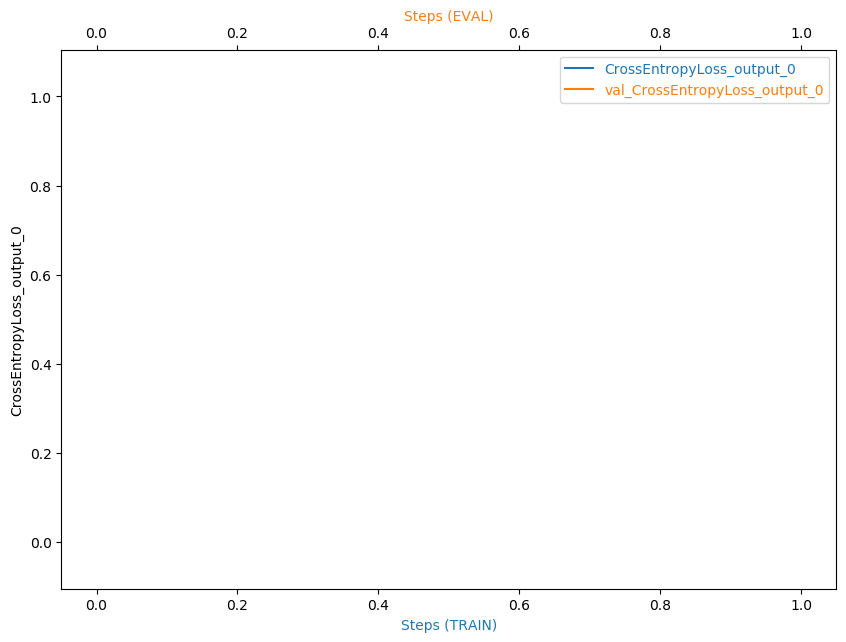

In [37]:
plot_tensor(trial,'CrossEntropyLoss_output_0')

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [52]:
# Notes: anomalous behaviour in your debugging output?
# - For first attempt, I'm getting 0 length for tensor: 'CrossEntropyLoss_output_0'. Perhaps to do with only 1 epoch?
# - Continuing with rest of notebook before trying with more epochs
# - also, perhaps good to look at train function solution in debugging/profiling exercise: https://learn.udacity.com/nanodegrees/nd189/parts/cd0387/lessons/29c31245-eeb5-412b-a09b-ec6e06df10fc/concepts/dbff54d9-a3da-45cb-9646-be7ec95d391b
# - also, I've since added hook.register_loss(loss_criterion) to main function in train_model.py

In [ ]:
# TODO: Display the profiler output
# - docs: https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-profiling-report.html

In [40]:
estimator.output_path

's3://sam-dl-project/train_model'

In [46]:
estimator.latest_training_job.job_name

'pytorch-training-2022-12-26-19-41-57-695'

In [50]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

! aws s3 ls {rule_output_path} --recursive

! aws s3 cp {rule_output_path} ./ --recursive

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

profiler_report_name

# this is only returning 'ProfilerReport'
# why is the expected report not generating??

'ProfilerReport'

In [ ]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [57]:
# TODO: Deploy your model to an endpoint

# Following these steps: https://knowledge.udacity.com/questions/775344
role = sagemaker.get_execution_role()
model_data = "s3://sam-dl-project/train_model/pytorch-training-2022-12-26-19-41-57-695/output/model.tar.gz"

In [62]:
from sagemaker.pytorch import PyTorchModel

pytorch_model = PyTorchModel(model_data=model_data, role=role, entry_point='inference.py', framework_version="1.8", py_version="py36")

predictor = pytorch_model.deploy(instance_type="ml.t2.medium", initial_instance_count=1)

---------!

In [63]:
# TODO: Run an prediction on the endpoint

# open, read a random test image
# https://stackoverflow.com/questions/55480467/how-to-load-image-data-from-s3-bucket-to-sagemaker-notebook
from PIL import ImageFile
import s3fs

fs = s3fs.S3FileSystem()

with fs.open ("s3://sam-dl-project/input_data/test/126.Saint_bernard/Saint_bernard_08020.jpg", "rb") as f:
    image = f.read()
    
response = predictor.predict(image)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from primary with message "Your invocation timed out while waiting for a response from container primary. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-inference-2022-12-26-22-28-18-979 in account 298604555843 for more information.

In [64]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()